# Survey Validation Data Challenge - Summer 2018

### Notebook 2 -- Tile the BGS/GAMA Fields and run survey simulations

The purpose of this notebook is to simulate DESI-like spectra of BGS targets bootstrapped from an input set of GAMA targets and redshifts, and then to run the spectra through the full DESI pipeline.

In [1]:
import os, sys, time, subprocess, pdb
import glob
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

In [2]:
import fitsio
from astropy.table import Table

In [3]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, palette='Set2')

In [4]:
%matplotlib inline

In [5]:
print("Starting at {}".format(time.asctime()))
notebook_start_time = time.time()

Starting at Fri Aug 24 09:48:01 2018


## Define various directories and input/output filenames.

Define and create directories under `$DESI_ROOT/datachallenge/svdc-summer2018` and set environment variables for this mapping:

| Directory             | NB variable   | Environment Variable                              |
|-----------------------|---------------|---------------------------------------------------|
| survey/               | surveydir     | \$DESISURVEY_OUTPUT                               |
| targets/              | targetdir     |                                                   |
| fiberassign/          | fibassigndir  |                                                   |
| spectro/redux/mini/   | reduxdir      | \$DESI_SPECTRO_REDUX/\$SPECPROD                   |
| spectro/sim/mini/     | simdatadir    | \$DESI_SPECTRO_DATA = \$DESI_SPECTRO_SIM/$PIXPROD |

In [6]:
if True:
    basedir = os.path.join(os.getenv('SCRATCH'), 'svdc-summer2018')
    codedir = os.path.join(os.getenv('SCRATCH'), 'repos', 'survey-validation', 'svdc-summer2018')
else:
    basedir = os.path.join(os.getenv('DESI_ROOT'), 'datachallenge', 'svdc-summer2018')
    codedir = os.path.join(os.getenv('DESI_PRODUCT_ROOT'), 'survey-validation', 'svdc-summer2018')

In [7]:
surveydir = os.path.join(basedir, 'survey')
targetdir = os.path.join(basedir, 'targets')
fibassigndir = os.path.join(basedir, 'fiberassign')

os.environ['DESISURVEY_OUTPUT'] = surveydir
os.environ['DESI_SPECTRO_REDUX'] = os.path.join(basedir, 'spectro', 'redux')
os.environ['DESI_SPECTRO_SIM'] = os.path.join(basedir, 'spectro', 'sim')
os.environ['PIXPROD'] = 'bgs-gama'
os.environ['SPECPROD'] = 'bgs-gama'

reduxdir = os.path.join(os.environ['DESI_SPECTRO_REDUX'], os.environ['SPECPROD'])
simdatadir = os.path.join(os.environ['DESI_SPECTRO_SIM'], os.environ['PIXPROD'])
os.environ['DESI_SPECTRO_DATA'] = simdatadir

for dd in (surveydir, targetdir, fibassigndir, reduxdir, simdatadir):
    os.makedirs(dd, exist_ok=True)

In [8]:
samplefile = os.path.join(basedir, 'GAMA-DR3', 'bgs-gama-sample.fits')
tilesfile = os.path.join(codedir, 'bgs-gama-tiles.fits')
surveyconfigfile = os.path.join(codedir, 'survey-config.yaml')
surveyrulesfile = os.path.join(codedir, 'rules.yaml')

#### Specify the random seed for reproducibility of the survey simulations.

In [9]:
seed = 123

In [10]:
nside_mock_targets = 64

#### Specify which steps should be redone (only used if the output files already exist).

If any of the following arguments are *True* then all the associated output files and plots will be recreated.  Warning: many of these steps are time-consuming (especially the mock spectra portion of the pipeline).

In [11]:
overwrite_tiles = True
overwrite_surveysim = True
overwrite_mock_spectra = True
overwrite_fiberassign = True
overwrite_simspec = True

## Read the parent sample of GAMA targets.
This parent sample was written by the *bgs-gama-sample.ipynb* notebook.

In [12]:
def read_gama_sample():
    if os.path.isfile(samplefile):
        gama = Table(fitsio.read(samplefile, ext=1))
        print('Read {} objects from {}'.format(len(gama), samplefile))
    else:
        print('Sample file {} not found!'.format(samplefile))
        gama = []
    return gama

In [13]:
gama = read_gama_sample()
gama

Read 123646 objects from /global/cscratch1/sd/ioannis/svdc-summer2018/GAMA-DR3/bgs-gama-sample.fits


CATAID,GAMA_NAME,IC_FLAG,N_SPEC,N_GAMA_SPEC,DIST,SPECID,SURVEY,SURVEY_CODE,RA_GAMA,DEC_GAMA,WMIN,WMAX,Z,NQ,PROB,FILENAME,URL,URL_IMG,D4000N,HB_EW,HA_EW,FIELD,RELEASE,BRICKID,BRICKNAME,OBJID,TYPE,RA,DEC,RA_IVAR,DEC_IVAR,DCHISQ [5],EBV,FLUX_U,FLUX_G,FLUX_R,FLUX_I,FLUX_Z,FLUX_Y,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_U,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_I,FLUX_IVAR_Z,FLUX_IVAR_Y,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_U,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_I,MW_TRANSMISSION_Z,MW_TRANSMISSION_Y,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,NOBS_U,NOBS_G,NOBS_R,NOBS_I,NOBS_Z,NOBS_Y,NOBS_W1,NOBS_W2,NOBS_W3,NOBS_W4,RCHISQ_U,RCHISQ_G,RCHISQ_R,RCHISQ_I,RCHISQ_Z,RCHISQ_Y,RCHISQ_W1,RCHISQ_W2,RCHISQ_W3,RCHISQ_W4,FRACFLUX_U,FRACFLUX_G,FRACFLUX_R,FRACFLUX_I,FRACFLUX_Z,FRACFLUX_Y,FRACFLUX_W1,FRACFLUX_W2,FRACFLUX_W3,FRACFLUX_W4,FRACMASKED_U,FRACMASKED_G,FRACMASKED_R,FRACMASKED_I,FRACMASKED_Z,FRACMASKED_Y,FRACIN_U,FRACIN_G,FRACIN_R,FRACIN_I,FRACIN_Z,FRACIN_Y,ANYMASK_U,ANYMASK_G,ANYMASK_R,ANYMASK_I,ANYMASK_Z,ANYMASK_Y,ALLMASK_U,ALLMASK_G,ALLMASK_R,ALLMASK_I,ALLMASK_Z,ALLMASK_Y,WISEMASK_W1,WISEMASK_W2,PSFSIZE_U,PSFSIZE_G,PSFSIZE_R,PSFSIZE_I,PSFSIZE_Z,PSFSIZE_Y,PSFDEPTH_U,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_I,PSFDEPTH_Z,PSFDEPTH_Y,GALDEPTH_U,GALDEPTH_G,GALDEPTH_R,GALDEPTH_I,GALDEPTH_Z,GALDEPTH_Y,WISE_COADD_ID,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_R_IVAR,SHAPEDEV_E1,SHAPEDEV_E1_IVAR,SHAPEDEV_E2,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_R_IVAR,SHAPEEXP_E1,SHAPEEXP_E1_IVAR,SHAPEEXP_E2,SHAPEEXP_E2_IVAR,MAGGIES [3],IVARMAGGIES [3],BESTMAGGIES [3],MASS,COEFFS [5],CHI2,CFLUX_4861,CFLUX_6563,UGRIZ_ABSMAG_01 [5],UGRIZ_ABSMAG_01_IVAR [5],UGRIZ_KCORRECT_01 [5]
int32,bytes23,int16,int16,int16,float32,bytes33,bytes9,int16,float64,float64,float32,float64,float32,int16,float32,bytes67,bytes88,bytes92,float32,float32,float32,bytes9,int32,int32,bytes8,int32,bytes4,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,uint8,uint8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
6802,GAMAJ113601.43+004315.3,4104,1,1,0.07,G12_Y3_017_187,GAMA,5,174.006,0.72093,3727.71,8857.67,0.05054,4,1.0,/GAMA/dr3/data/spectra/gama/reduced_27/1d/G12_Y3_017_187.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/G12_Y3_017_187.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/png/G12_Y3_017_187.png,1.81131,5.20334,27.8028,G12,5000,335384,1741p007,1933,EXP,174.005986224,0.72093939323,6.98847e+12,4.19143e+12,419401.0 .. 536836.0,0.0223431,0.0,21.8932,36.975,0.0,53.059,0.0,34.9711,24.9659,34.9948,13.339,0.0,312.894,194.109,0.0,48.3468,0.0,1.45916,0.288661,0.000888833,2.01304e-05,0.921076,0.936,0.956425,0.967769,0.975387,0.978342,0.996221,0.997677,0.999504,0.999813,0,7,7,0,6,0,71,71,14,14,0.0,1.26588,1.34202,0.0,1.43137,0.0,1.38022,0.931167,0.514855,0.223534,0.0,1.74706e-09,-2.69563e-09,0.0,-1.60942e-09,0.0,0.00462063,0.02367,0.425635,19.0078,0.0,0.00590022,0.00641236,0.0,0.00359081,0.0,0.0,1.01567,1.01286,0.0,1.02181,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.6335,1.44952,0.0,1.29571,0.0

## Visualize the tiling of the G02, G09, G12, and G15 GAMA fields.

Here, we use a tiling solution generated by Kyle Dawson but we change the program name to DARK and set OBSCONDITIONS to zero (=DARK) until the appropriate hooks can be added to *desisurvey*.

In [14]:
def fix_tiles():
    """Ad hoc changes to the nominal tile file so we can get desisurvey running.
    
    """
    dawsonfile = os.path.join(codedir, 'bgs-gama-tiles-kdawson.fits')
    if os.path.isfile(dawsonfile):
        tiles = Table(fitsio.read(tilesfile, ext=1))
        print('Updating PROGRAM and OBSCONDITIONS in {}'.format(dawsonfile))
        tiles['PASS'] = 1
        tiles['PROGRAM'] = 'DARK'
        tiles['OBSCONDITIONS'] = 0 # dark
        print('Writing {}'.format(tilesfile))
        tiles.write(tilesfile, overwrite=True)
    else:
        print('Dawson tiles file {} not found!'.format(dawsonfile))

In [15]:
def plot_tile(ra, dec, r=1.606, color='k', ax=None):
    '''Approximate plot of tile location'''
    ang = np.linspace(0, 2*np.pi, 100)
    x = ra + r*np.cos(ang)/np.cos(np.radians(dec))
    y = dec + r*np.sin(ang)
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(x,y, '-', color=color, alpha=0.5)

In [16]:
def read_gama_tiles(overwrite=False):
    """Read the tiles file."""
    
    if overwrite:
        fix_tiles()
    
    if os.path.isfile(tilesfile):
        tiles = Table(fitsio.read(tilesfile, ext=1))
        print('Read {} tiles from {}'.format(len(tiles), tilesfile))
    else:
        print('Tiles file {} not found!'.format(tilesfile))
        tiles = []
    return tiles

In [17]:
def qa_gama_tiles(gama=None, tiles=None, gamafield=None, overwrite=False):
    
    if gama is None:
        gama = read_gama_sample()
    if tiles is None:
        tiles = read_gama_tiles()

    fig, ax = plt.subplots(2, 2, figsize=(10, 6))
    ax = ax.reshape(4)
    
    for thisax, field in zip(ax, sorted(set(gama['FIELD']))):
        
        infield = gama['FIELD'] == field
    
        if np.count_nonzero(infield) > 0:
            thisax.scatter(gama['RA'][infield], gama['DEC'][infield], 
                           s=1, alpha=0.5, marker='s')
        
            ww = ( (tiles['RA'] > gama['RA'][infield].min()) * (tiles['RA'] < gama['RA'][infield].max()) * 
                   (tiles['DEC'] > gama['DEC'][infield].min()) * (tiles['DEC'] < gama['DEC'][infield].max()) )
            for tt in tiles[ww]:
                plot_tile(tt['RA'], tt['DEC'], ax=thisax)
            
        thisax.set_xlabel('RA')
        thisax.set_ylabel('Dec')
        thisax.invert_xaxis()
        thisax.set_title(field)
    
    fig.tight_layout()
    if overwrite:
        pngfile = os.path.join(basedir, 'qaplots', 'qa-gama-tiles.png')
        print('Writing {}'.format(pngfile))
        fig.savefig(pngfile)    

In [18]:
tiles = read_gama_tiles(overwrite=overwrite_tiles)
tiles

Updating PROGRAM and OBSCONDITIONS in /global/cscratch1/sd/ioannis/repos/survey-validation/svdc-summer2018/bgs-gama-tiles-kdawson.fits
Writing /global/cscratch1/sd/ioannis/repos/survey-validation/svdc-summer2018/bgs-gama-tiles.fits
Read 94 tiles from /global/cscratch1/sd/ioannis/repos/survey-validation/svdc-summer2018/bgs-gama-tiles.fits


TILEID,RA,DEC,PASS,IN_DESI,EBV_MED,AIRMASS,STAR_DENSITY,EXPOSEFAC,PROGRAM,OBSCONDITIONS
int32,float64,float64,int16,int16,float32,float32,float32,float32,bytes6,int32
100000,212.399993896,-0.819999992847,1,1,0.0504712,1.0,1.0,1.0,DARK,0
100001,213.199996948,-0.800000011921,1,1,0.0498524,1.0,1.0,1.0,DARK,0
100002,214.0,-0.77999997139,1,1,0.049985,1.0,1.0,1.0,DARK,0
100003,214.799987793,-0.759999990463,1,1,0.0459586,1.0,1.0,1.0,DARK,0
100004,215.599990845,-0.819999992847,1,1,0.0451689,1.0,1.0,1.0,DARK,0
100005,216.399993896,-0.800000011921,1,1,0.042806,1.0,1.0,1.0,DARK,0
100006,217.199996948,-0.77999997139,1,1,0.0435473,1.0,1.0,1.0,DARK,0
100007,218.0,-0.759999990463,1,1,0.042242,1.0,1.0,1.0,DARK,0
100008,218.799987793,-0.819999992847,1,1,0.042335,1.0,1.0,1.0,DARK,0


Writing /global/cscratch1/sd/ioannis/svdc-summer2018/qaplots/qa-gama-tiles.png


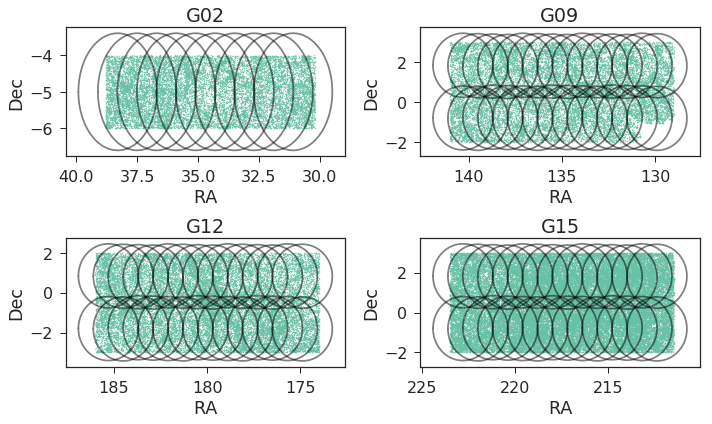

In [19]:
qa_gama_tiles(gama, tiles, overwrite=overwrite_tiles)

## Run survey simulations (currently deprecated)

The code below enables one to simulate SV observations of the GAMA fields using *desisurvey*.  However, since the dates of SV are still uncertain (and three of the four GAMA fields are spring or late-fall fields) we have opted to simulate observing conditions by simply drawing from the full-survey simulations.

In [20]:
def survey_simulations(tiles, overwrite=False):
    """Run survey simulations."""
    expfile = os.path.join(surveydir, 'exposures.fits')
    progressfile = os.path.join(surveydir, 'progress.fits')
    
    if overwrite or not os.path.isfile(expfile):
        from desisurvey.progress import Progress
        from desisurvey.config import Configuration
        from surveysim.util import add_calibration_exposures
    
        Configuration.reset()
        config = Configuration(surveyconfigfile)

        survey_logname = os.path.join(surveydir, 'survey.log')
        print('Running survey simulations; logging to {}'.format(survey_logname)) ; print()
        
        with open(survey_logname, 'w') as logfile:
            cmd = "surveyinit --recalc --config-file {} --output-path {}".format(surveyconfigfile, surveydir)
            print(cmd) ; print()
            err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
            assert err == 0

            # Assume a zero-day fiber assignment delay..
            cmd = "surveyplan --config-file {} --rules {} --output-path {} --create --fa-delay 0d".format(
                surveyconfigfile, surveyrulesfile, surveydir)
            print(cmd) ; print()
            err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
            assert err == 0

            cmd = "surveysim --config-file {} --output-path {} --seed {}".format(
                surveyconfigfile, surveydir, seed)
            print(cmd) ; print()
            err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
            assert err == 0

            # Do we need new rules?!?
            plan_cmd = 'surveyplan --config-file {} --rules {} --output-path {} --fa-delay 0d'.format(
                surveyconfigfile, surveyrulesfile, surveydir)
            sim_cmd = 'surveysim --resume --config-file {} --output-path {} --seed {}'.format(
                surveyconfigfile, surveydir, seed)
            print(sim_cmd) ; print()
            while True:
                lastdate = open(os.path.join(surveydir, 'last_date.txt')).readline().strip()
                progress = Table.read(os.path.join(surveydir, 'progress.fits'), 1)
                ndone = np.count_nonzero(progress['status'] == 2)
                print('Starting {} with {}/{} tiles completed {}'.format(
                    lastdate, ndone, len(progress), time.asctime()))
                if subprocess.call(plan_cmd.split(), stdout=logfile, stderr=logfile) != 0:
                    break
                if subprocess.call(sim_cmd.split(), stdout=logfile, stderr=logfile) != 0:
                    break

        # Make sure observing truly finished.
        if not os.path.exists(progressfile):
            print("ERROR: Missing {}".format(progressfile))
            print("Check {} for what might have gone wrong".format(survey_logname))
    
        print('Files in {}:\n'.format(surveydir))
        !ls $surveydir
        
        # convert progress.fits -> exposures.fits
        p = Progress(restore=os.path.join(surveydir, 'progress.fits'))
        explist = p.get_exposures()
        explist = add_calibration_exposures(explist)

        # Sanity check that all tiles in the subset were observed in the exposures list.
        if not np.all(np.in1d(tiles['TILEID'], explist['TILEID'])):
            print("ERROR: some tiles weren't observed;\ncheck {} for failures".format(survey_logname) )
            print("Missing TILEIDs:", set(tiles['TILEID']) - set(explist['TILEID']))
        else:
            print('All tiles in the subset were observed at least once.')
            explist.write(expfile, overwrite=True)
            print('Writing {}'.format(expfile))                

        # Optionally make a movie
        if False:
            cmd = "surveymovie --config-file {} --output-path {}".format(
                surveyconfigfile, surveydir)
            err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
            assert err == 0
    else:
        print('Simulated observing already completed.')
        explist = Table.read(expfile)
        print('Read {} exposures from {}'.format(len(explist), expfile))

    return explist

In [65]:
def sample_survey_simulations(tiles, overwrite=False, seed=None):
    """Generate the exposures file by drawing from the 2017 full-survey 
    simulations.
    
    """
    expfile = os.path.join(surveydir, 'exposures.fits')
    if overwrite or not os.path.isfile(expfile):
        from astropy.table import vstack
        from surveysim.util import add_calibration_exposures

        rand = np.random.RandomState(seed)
    
        simexpfile = os.path.join(os.getenv('DESI_ROOT'), 'datachallenge', 
                                  'surveysim2017', 'depth_0m', 'exposures.fits')
        if not os.path.isfile(simexpfile):
            print('Exposures file {} not found!'.format(simexpfile))
            raise IOError
        exp = Table.read(simexpfile)
        print('Read {} parent exposures from {}'.format(len(exp), simexpfile))

        _, uniq = np.unique(exp['TILEID'].data, return_index=True) # flag CR splits
        
        explist = []
        for tt in tiles:
            # Find exposures with the correct PROGRAM and close in Galactic 
            # reddening and then choose one at random (with uniform probability).
            # If there is more than one exposure, take both (CR split).
            
            ww = np.where( (exp['PROGRAM'][uniq] == tt['PROGRAM']) * 
                           (np.abs(exp['EBMV'][uniq]-tt['EBV_MED']) < 0.02) )[0]
            if np.count_nonzero(ww) == 0:
                ww = np.where( (exp['PROGRAM'][uniq] == tt['PROGRAM']) * 
                               (np.abs(exp['EBMV'][uniq]-tt['EBV_MED']) < 0.05) )[0]
                if np.count_nonzero(ww) == 0:
                    print('Insufficient comparable exposures!')
                    raise ValueError
                
            this = rand.choice(ww) # choose one at random
            these = exp['TILEID'] == exp['TILEID'][uniq][this] # bring back CR splits
            _explist = vstack(exp[these])
            
            # Replace data from the tile.
            _explist['TILEID'] = tt['TILEID']
            _explist['PASS'] = tt['PASS']
            _explist['EBMV'] = tt['EBV_MED']
            _explist['RA'] = tt['RA']
            _explist['DEC'] = tt['DEC']
            explist.append(_explist)

        explist = vstack(explist)
        
        # Assign all 94 tiles to a single (wonderful) NIGHT and MJD.
        this = np.where( exp['NIGHT'].data == '20191201' )[0][0]
        explist['NIGHT'][:] = exp['NIGHT'][this]
        explist['MJD'][:] = exp['MJD'][this]
        
        explist = add_calibration_exposures(explist)
        explist['EXPID'] = np.arange(len(explist)) # sequential IDs

    else:
        print('Simulated observing already completed.')
        explist = Table.read(expfile)
        print('Read {} exposures from {}'.format(len(explist), expfile))

    return explist

In [66]:
#%time explist = survey_simulations(tiles, overwrite=overwrite_surveysim)
%time explist = sample_survey_simulations(tiles, overwrite=overwrite_surveysim, seed=seed)
explist

Read 26791 parent exposures from /global/project/projectdirs/desi/datachallenge/surveysim2017/depth_0m/exposures.fits
CPU times: user 886 ms, sys: 9.83 ms, total: 896 ms
Wall time: 912 ms


EXPID,TILEID,PASS,RA,DEC,EBMV,NIGHT,MJD,EXPTIME,SEEING,TRANSPARENCY,AIRMASS,MOONFRAC,MOONALT,MOONSEP,PROGRAM,FLAVOR
,,,deg,deg,,,,s,arcsec,,,,deg,deg,,
int64,int32,int16,float64,float64,float32,str8,float64,float64,float64,float64,float64,float64,float64,float64,str6,str7
0,-1,-1,0.0,0.0,0.0,20191201,58819.0555924,10.0,0.0,0.0,0.0,0.0,0.0,0.0,CALIB,arc
1,-1,-1,0.0,0.0,0.0,20191201,58819.0560553,10.0,0.0,0.0,0.0,0.0,0.0,0.0,CALIB,arc
2,-1,-1,0.0,0.0,0.0,20191201,58819.0565183,10.0,0.0,0.0,0.0,0.0,0.0,0.0,CALIB,arc
3,-1,-1,0.0,0.0,0.0,20191201,58819.0569812,10.0,0.0,0.0,0.0,0.0,0.0,0.0,CALIB,flat
4,-1,-1,0.0,0.0,0.0,20191201,58819.0574442,10.0,0.0,0.0,0.0,0.0,0.0,0.0,CALIB,flat
5,-1,-1,0.0,0.0,0.0,20191201,58819.0579072,10.0,0.0,0.0,0.0,0.0,0.0,0.0,CALIB,flat
6,100000,1,212.399993896,-0.819999992847,0.0504712,20191201,58819.0583701,1014.97340904,1.90617179871,0.971030652523,1.12834057753,0.014665698581,-49.3509152472,117.584981485,DARK,science
7,100000,1,212.399993896,-0.819999992847,0.0504712,20191201,58819.0583701,1084.5175396,1.90617179871,0.971030652523,1.12834057753,0.014665698581,-49.3509152472,117.584981485,DARK,science


#### Visualize which healpixels cover the observed tiles.

In [67]:
def plot_healpix(nside, pixels, ax=None):
    '''Plot healpix boundaries; doesn't work at RA wraparound'''
    if ax is None:
        fig, ax = plt.subplots()
    for p in pixels:
        xyz = hp.boundaries(nside, p, nest=True)
        theta, phi = hp.vec2ang(xyz.T)
        theta = np.concatenate([theta, theta[0:1]])
        phi = np.concatenate([phi, phi[0:1]])
        ra, dec = np.degrees(phi), 90-np.degrees(theta)
        ax.plot(ra, dec, '-', color='0.6') 

In [68]:
def tiles2pixels(tiles, nside=64):
    import desimodel.footprint
    pixels = desimodel.footprint.tiles2pix(nside, tiles)
    nexp = np.count_nonzero(np.in1d(explist['TILEID'], tiles['TILEID']))
    print('{} tiles covered by {} exposures and {} nside={} healpixels'.format(
        len(tiles), nexp, len(pixels), nside))
    return pixels

In [69]:
def qa_observed_tiles():
    isbright = explist['PROGRAM'] == 'BRIGHT'
    isgray = explist['PROGRAM'] == 'GRAY'
    isdark = explist['PROGRAM'] == 'DARK'
    
    fig, ax = plt.subplots()
    ax.plot(tiles['RA'], tiles['DEC'], 'k.', alpha=0.2, label='_none_')
    ax.plot(explist['RA'][isdark], explist['DEC'][isdark], 'o', color='k', ms=10, mew=2, label='dark')
    if np.sum(isgray) > 0:
        ax.plot(explist['RA'][isgray], explist['DEC'][isgray], 's', 
                color='0.6', ms=10, label='gray')
    if np.sum(isbright) > 0:
        ax.plot(explist['RA'][isbright], explist['DEC'][isbright], 'd', 
                color='m', ms=10, mew=2, label='bright')
    ax.legend(loc='upper right')
    #ax.set_xlim(148, 157)
    #ax.set_ylim(28, 37)

In [70]:
def qa_tiles2pixels(tiles, nside=64, overwrite=False):
    
    pixels = tiles2pixels(tiles, nside=nside)
    sci = explist['FLAVOR'] == 'science'
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    ax1.scatter(explist['RA'][sci], explist['DEC'][sci], marker='o', 
                alpha=0.7, label='Exposures')
    ax1.scatter(tiles['RA'], tiles['DEC'], marker='s', edgecolor='k', 
                facecolor='none', lw=2, label='Tile Centers')
    ax1.legend(loc='upper left', markerscale=1.5)
    ax1.invert_xaxis()
    ax1.set_xlabel('RA')
    ax1.set_ylabel('Dec')

    plot_healpix(nside, pixels, ax=ax2)
    color = dict(DARK='k', GRAY='b', BRIGHT='m')
    for program in ['DARK', 'GRAY', 'BRIGHT']:
        ii = (tiles['PROGRAM'] == program)
        ax2.plot(tiles['RA'][ii], tiles['DEC'][ii], '.', color=color[program], alpha=0.5)
        jj = tiles['PROGRAM'] == program
        for t in tiles[jj]:
            plot_tile(t['RA'], t['DEC'], color=color[program], ax=ax2)
            
    xlim = ax2.get_xlim()
    ax2.set_xlim(xlim)
    ax1.set_xlim(xlim)
    #xlim(143, 161); ylim(28, 37)
    
    fig.tight_layout()
    if overwrite:
        pngfile = os.path.join(basedir, 'qaplots', 'qa-gama-tiles-healpixels.png')
        print('Writing {}'.format(pngfile))
        fig.savefig(pngfile)        
    
    return pixels

94 tiles covered by 183 exposures and 428 nside=64 healpixels
Writing /global/cscratch1/sd/ioannis/svdc-summer2018/qaplots/qa-gama-tiles-healpixels.png


array([ 4096,  4097,  4098,  4099,  4100,  4101,  4102,  4103,  4104,
        4105,  4106,  4107,  4108,  4109,  4110,  4112,  4113,  4114,
        4128,  4129,  4130,  8194,  8195,  8200,  8201,  8202,  8203,
        8224,  8225,  8226, 17669, 17670, 17671, 17673, 17674, 17675,
       17676, 17677, 17678, 17679, 17680, 17681, 17682, 17683, 17684,
       17685, 17686, 17687, 17688, 17689, 17690, 17691, 17692, 17693,
       17694, 17695, 17696, 17697, 17698, 17699, 17700, 17701, 17702,
       17703, 17704, 17705, 17706, 17707, 17708, 17709, 17710, 17711,
       17712, 17713, 17714, 17715, 17716, 17720, 17728, 17730, 17736,
       21827, 21828, 21829, 21830, 21831, 21833, 21835, 21836, 21837,
       21838, 21839, 21840, 21841, 21842, 21843, 21844, 21845, 21846,
       21847, 21848, 21849, 21850, 21851, 21852, 21853, 21854, 21855,
       21860, 21861, 21872, 21873, 21874, 21875, 21876, 21877, 21878,
       21879, 21880, 21881, 21883, 21884, 21885, 21886, 25565, 25566,
       25567, 25581,

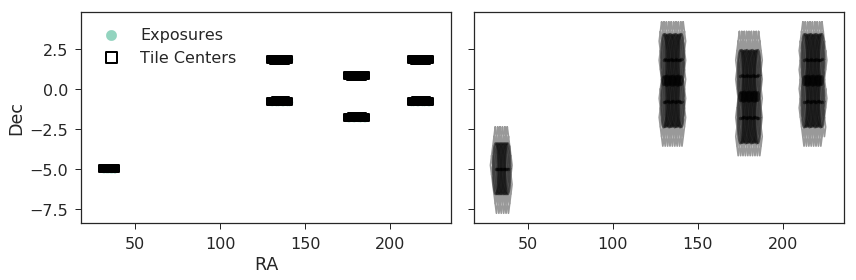

In [73]:
pixels = qa_tiles2pixels(tiles, nside=nside_mock_targets, overwrite=overwrite_tiles)
pixels

In [ ]:
* separate these plots into four different fields
* plot up histograms of seeing, sky conditions, exposure time, etc.

## Simulate noiseless spectra using select_mock_targets.

Then, merge the target, sky, and stdstar catalogs and build the Merged Target List (MTL) file.

In [ ]:
def is_select_mock_targets_done(tilesfile, nside=64, verbose=False):
    """Check whether select_mock_targets successfully finished."""
    tiles = Table(fitsio.read(tilesfile, ext=1))
    pixels = tiles2pixels(tiles, nside=nside)
    
    done = True
    for filetype in ['target', 'truth', 'sky', 'standards-dark', 'standards-bright']:
        filenames = glob.glob(os.path.join(targetdir, '*', '*', '{}*.fits'.format(filetype)))
        if verbose:
            print('{}/{} {} files'.format(len(filenames), len(pixels), filetype))
        if len(filenames) != len(pixels):
            done = False
    return done

In [ ]:
def select_mock_targets(tilesfile, nside=64, overwrite=False, verbose=False):
    """Run select_mock_targets."""
    
    logfilename = os.path.join(targetdir, 'select_mock_targets.log')
    if overwrite or not is_select_mock_targets_done(tilesfile, nside=nside, verbose=verbose):
            
        print('Starting select_mock_targets at {}'.format(time.asctime()))
        print('Logging to {}'.format(logfilename))

        configfile = os.path.join(codedir, 'mock-targets.yaml')
    
        #cmd = "srun -A desi -N 15 -n 30 -c 16 -C haswell -t 00:30:00 --qos interactive"
        #cmd += " mpi_select_mock_targets --output_dir {targetdir} --config {configfile}"
        #cmd += " --seed 1 --nproc 16 --nside 64 --tiles {tilefile}"
    
        cmd = "select_mock_targets --output_dir {targetdir} --config {configfile}"
        cmd += " --seed {seed} --nproc 4 --nside {nside} --tiles {tilesfile} --overwrite"
        cmd = cmd.format(targetdir=targetdir, tilesfile=tilesfile, configfile=configfile, 
                         seed=seed, nside=nside)
        print(cmd)
    
        with open(logfilename, 'w') as logfile:
            err = subprocess.call(cmd.split(), stderr=logfile, stdout=logfile)
            if err != 0:
                print('select_mock_targets failed err={}; see {}'.format(err, logfilename))
            else:
                print('done at {}'.format(time.asctime()))
                
    else:
        print('All done with select_mock_targets; see log file {}'.format(logfilename))            

In [ ]:
def join_targets_truth_mtl(overwrite=False):
    mtlfile = os.path.join(targetdir, 'mtl.fits')
    truthfile = os.path.join(targetdir, 'truth.fits')
    targetsfile = os.path.join(targetdir, 'targets.fits')

    if (overwrite or not os.path.isfile(mtlfile) or not os.path.isfile(targetsfile) or
        not os.path.isfile(truthfile)):
        
        cmd = "join_mock_targets --mockdir {} --force".format(targetdir)
        print(cmd)
        err = subprocess.call(cmd.split())
        if err != 0:
            print('join_mock_targets failed err={}'.format(err))
        else:
            print('Successfully joined all targets and truth catalogs.')
    else:
        print('Using existing truth.fits {}'.format(truthfile))        
        print('Using existing targets.fits file {}'.format(targetsfile))        
        print('Using existing merged target list {}'.format(mtlfile))        

In [ ]:
%time select_mock_targets(G02tilesfile, nside=nside_mock_targets, verbose=True, overwrite=overwrite_mock_spectra)

In [ ]:
%time join_targets_truth_mtl(overwrite=overwrite_mock_spectra)

#### [ToDo] Targeting QA.

## Fiber assignment

In [ ]:
def is_fiberassign_done(tilesfile, verbose=False):
    """Check whether fiberassign successfully finished."""
    
    tiles = Table(fitsio.read(tilesfile, ext=1))
    done = True
    for tileid in tiles['TILEID']:
        tilefile = os.path.join(fibassigndir, 'tile_{:05d}.fits'.format(tileid))
        if not os.path.exists(tilefile):
            done = False
            if verbose:
                print('Missing {}'.format(tilefile))

    return done

In [ ]:
def run_fiberassign(tilesfile, overwrite=False, verbose=False):
    
    logfilename = os.path.join(fibassigndir, 'fiberassign.log')
    if overwrite or not is_fiberassign_done(tilesfile, verbose=verbose):

        print('Generating lists of dark and bright tiles')
        tiles = Table(fitsio.read(tilesfile, ext=1))

        bx, dx = None, None
        for tileid, program  in zip(tiles['TILEID'], tiles['PROGRAM']):
            if program == 'BRIGHT':
                if bx is None:
                    bx = open(os.path.join(fibassigndir, 'bright-tiles.txt'), 'w')
                bx.write(str(tileid)+'\n')
            else:
                if dx is None:
                    dx = open(os.path.join(fibassigndir, 'dark-tiles.txt'), 'w')
                dx.write(str(tileid)+'\n')
        if bx:
            bx.close()
        if dx:
            dx.close()

        # Remove any leftover tile files
        for tilefile in glob.glob(fibassigndir+'/tile_*.fits'):
            os.remove(tilefile)

        cmd = "fiberassign "
        cmd += " --mtl {}/mtl.fits".format(targetdir)
        cmd += " --stdstar {}/{{stdfile}}".format(targetdir)
        cmd += " --sky {}/sky.fits".format(targetdir)
        cmd += " --surveytiles {}/{{surveytiles}}".format(fibassigndir)
        cmd += " --footprint {tilesfile}"
        #cmd += " --positioners {}/data/focalplane/fiberpos.fits".format(os.getenv('DESIMODEL'))
        cmd += " --fibstatusfile {}/fiberstatus.ecsv".format(codedir)
        cmd += " --outdir {}".format(fibassigndir)

        # Run fiberassign
        print('Logging to {}'.format(logfilename)) ; print()
        with open(logfilename, 'w') as logfile:
            for program in ['dark', 'bright']:
                stdfile = 'standards-{}.fits'.format(program)
                surveytiles = '{}-tiles.txt'.format(program)
                if os.path.isfile(os.path.join(fibassigndir, surveytiles)):
                    cmdx = cmd.format(stdfile=stdfile, surveytiles=surveytiles,
                                      tilesfile=tilesfile)
                    print(cmdx)
                
                    err = subprocess.call(cmdx.split(), stdout=logfile, stderr=logfile)
                    if err != 0:
                        print('fiberassign failed err={}; see {}'.format(err, logfilename))
        
        if is_fiberassign_done(tilesfile, verbose=True):
            print('Success; running QA.')
            print()
            !qa-fiberassign $fibassigndir/tile*.fits --targets $targetdir/targets.fits
            #cmd = 'qa-fiberassign {}/tile*.fits'.format(fibassigndir)
            #cmd += ' --targets {}/targets.fits'.format(targetdir)
            #print(cmd)
            #err = subprocess.call(cmd.split(), stdout=subprocess.PIPE)#, stderr=logfile)#, stderr=sys.stderr)
        else:
            print('ERROR: missing fiberassign output files')
        
    else:
        print('Finished fiber assignment; see log file {}'.format(logfilename))            

In [ ]:
%time run_fiberassign(G02tilesfile, overwrite=overwrite_fiberassign)

### Combine surveysim, mocks, and fiberassign into simspec files.

[This step took roughly 27 minutes on my laptop with two tiles.]

In [ ]:
def is_newexp_done(explist, verbose=False):    
    numnights = len(set(explist['NIGHT']))
    nexp = len(explist)  #- 3 arc/night + 3 flat/night + science
    simspecfiles = glob.glob(simdatadir+'/*/simspec*.fits')
    fibermapfiles = glob.glob(simdatadir+'/*/fibermap*.fits')
    if verbose:
        print('{}/{} simspec files'.format(len(simspecfiles), nexp))
        print('{}/{} fibermap files'.format(len(fibermapfiles), nexp))

    if len(simspecfiles) != nexp:
        return False
    elif len(fibermapfiles) != nexp:
        return False
    else:
        return True

In [ ]:
def run_newexp(tilefile, explist, overwrite=False):
    """Run newexp."""
    
    logfilename = os.path.join(simdatadir, 'newexp.log')
    if overwrite or not is_newexp_done(explist):
        logfilename = os.path.join(simdatadir, 'newexp.log')
        print('Logging to {}'.format(logfilename))

        cmd = " wrap-newexp --fiberassign {}".format(fibassigndir)
        cmd += " --mockdir {}".format(targetdir)
        cmd += " --obslist {}/exposures.fits".format(surveydir)
        cmd += " --tilefile {}".format(tilefile)
        #cmd += " --dryrun"
        if overwrite:
            cmd += " --force"
        
        print('Starting at {}'.format(time.asctime()))
        if 'NERSC_HOST' in os.environ:
            nodes = 15
            nersc_cmd = "srun -A desi -N {nodes} -n {nodes} -c 32".format(nodes=nodes)
            nersc_cmd += " -C haswell -t 00:15:00 --qos interactive"
            cmd = nersc_cmd+cmd
        print(cmd)

        with open(logfilename, 'w') as logfile:
            err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
            if err != 0:
                print('ERROR {} running wrap-newexp; see {}'.format(err, logfilename))
            else:
                print('done')            
    else:
        print('newexp is done')
        is_newexp_done(explist, verbose=True)

In [ ]:
%time run_newexp(G02tilesfile, explist, overwrite=overwrite_simspec)

### Generate noisy uncalibrated spectra  using fastframe.

In [ ]:
def is_fastframe_done(explist, reduxdir, verbose=False):
    nflat = np.count_nonzero(explist['FLAVOR'] == 'flat')
    nscience = np.count_nonzero(explist['FLAVOR'] == 'science')
    nframe = 30*(nflat + nscience)
    framefiles = glob.glob(reduxdir+'/exposures/*/*/frame*.fits')
    if verbose:
        print('{}/{} frame files'.format(len(framefiles), nframe))
    
    if len(framefiles) != nframe:
        return False
    else:
        return True

In [ ]:
def run_fastframe(overwrite=False):
    if is_fastframe_done(explist, reduxdir, verbose=True):
        print('fastframe already done; skipping')
    else:
        logfilename = os.path.join(reduxdir, 'exposures', 'fastframe.log')
        os.makedirs(os.path.dirname(logfilename), exist_ok=True)
        print('Running fastframe batch job; should take ~7 min')
        print('Starting at {}'.format(time.asctime()))
        print('Logging to {}'.format(logfilename))
        
        nodes = 15

        cmd = "srun -A desi -N {nodes} -n {nodes} -c 32 -C haswell -t 00:20:00 --qos interactive".format(nodes=nodes)
        cmd += " wrap-fastframe --mpi"
        with open(logfilename, 'w') as logfile:
            err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
            if err != 0:
                print('ERROR {} running wrap-fastframe; see {}'.format(err, logfilename))
            else:
                print('done at {}'.format(time.asctime()))

        if is_fastframe_done(explist, reduxdir, verbose=True):
            print('SUCCESS')
        else:
            print('ERROR; see {}'.format(logfilename))